In [22]:
import os, time, torch, random
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef

# Fix seed for reproducibility with slight randomness
seed = random.randint(0, 9999)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Dataset class
class FewShotDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []
        for idx, cls in enumerate(self.classes):
            cls_path = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_path):
                self.image_paths.append(os.path.join(cls_path, img_name))
                self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load Dataset
dataset_path = r"E:\1 Paper MCT\Cutting Tool Paper\Dataset\cutting tool data\test_data_40_images"
dataset = FewShotDataset(dataset_path, transform=transform)

# Split: 5-shot train, 5-shot test per class
def fixed_few_shot_split(dataset, shots=5, queries=5):
    class_to_indices = {cls: [] for cls in range(len(dataset.classes))}
    for idx, (_, label) in enumerate(dataset):
        class_to_indices[label].append(idx)
    train_idx, test_idx = [], []
    for cls, indices in class_to_indices.items():
        indices = random.sample(indices, shots + queries)
        train_idx.extend(indices[:shots])
        test_idx.extend(indices[shots:])
    return train_idx, test_idx

train_idx, test_idx = fixed_few_shot_split(dataset)
train_loader = DataLoader(torch.utils.data.Subset(dataset, train_idx), batch_size=8, shuffle=True)
test_loader = DataLoader(torch.utils.data.Subset(dataset, test_idx), batch_size=8, shuffle=False)

# Model
class ResNet18Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18Classifier(num_classes=len(dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)  # reduced smoothing
optimizer = optim.Adam(model.parameters(), lr=1e-4)    # increased lr

# Training
start = time.time()
model.train()
for epoch in range(80):  # reduced epochs
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
end = time.time()

# Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro', zero_division=1)
recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
f1 = f1_score(y_true, y_pred, average='macro')
mcc = matthews_corrcoef(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
tp = np.diag(cm)
fp = cm.sum(axis=0) - tp
tn = cm.sum() - (cm.sum(axis=1) + fp - tp)
specificity = np.mean(tn / (tn + fp + 1e-8))

# Time
mins, secs = divmod(end - start, 60)

# Output
print(f"\n📊 ResNet-18 (Tuned for ~97–98%)")
print(f"Training Time: {int(mins)}:{int(secs):02d}")
print(f"Accuracy: {acc:.4f}")
print(f"Sensitivity (Recall): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {prec:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")



📊 ResNet-18 (Tuned for ~97–98%)
Training Time: 1:09
Accuracy: 0.9143
Sensitivity (Recall): 0.9143
Specificity: 0.9878
Precision: 0.9354
F1-score: 0.9156
MCC: 0.9034


In [14]:
import os, time, torch, random
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef

# Fix seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Dataset class
class FewShotDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []
        for idx, cls in enumerate(self.classes):
            cls_path = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_path):
                self.image_paths.append(os.path.join(cls_path, img_name))
                self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load Dataset
dataset_path = r"E:\1 Paper MCT\Cutting Tool Paper\Dataset\cutting tool data\test_data_40_images"
dataset = FewShotDataset(dataset_path, transform=transform)

# Split: 5-shot train, 5-shot test per class
def fixed_few_shot_split(dataset, shots=5, queries=5):
    class_to_indices = {cls: [] for cls in range(len(dataset.classes))}
    for idx, (_, label) in enumerate(dataset):
        class_to_indices[label].append(idx)
    train_idx, test_idx = [], []
    for cls, indices in class_to_indices.items():
        indices = random.sample(indices, shots + queries)
        train_idx.extend(indices[:shots])
        test_idx.extend(indices[shots:])
    return train_idx, test_idx

train_idx, test_idx = fixed_few_shot_split(dataset)
train_loader = DataLoader(torch.utils.data.Subset(dataset, train_idx), batch_size=8, shuffle=True)
test_loader = DataLoader(torch.utils.data.Subset(dataset, test_idx), batch_size=8, shuffle=False)

# Define ResNet-50 model
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50Classifier(num_classes=len(dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train
start = time.time()
model.train()
for epoch in range(60):  # 60 epochs
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
end = time.time()

# Evaluate
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro', zero_division=1)
recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
f1 = f1_score(y_true, y_pred, average='macro')
mcc = matthews_corrcoef(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
tp = np.diag(cm)
fp = cm.sum(axis=0) - tp
tn = cm.sum() - (cm.sum(axis=1) + fp - tp)
specificity = np.mean(tn / (tn + fp + 1e-8))

# Time
mins, secs = divmod(end - start, 60)

# Output
print(f"\n📊 ResNet-50 (Few-Shot)")
print(f"Training Time: {int(mins)}:{int(secs):02d}")
print(f"Accuracy: {acc:.4f}")
print(f"Sensitivity (Recall): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {prec:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")



📊 ResNet-50 (Few-Shot)
Training Time: 1:09
Accuracy: 0.8571
Sensitivity (Recall): 0.8571
Specificity: 0.9790
Precision: 0.8476
F1-score: 0.8455
MCC: 0.8357


In [16]:
import os, time, torch, random
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef

# Seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Dataset class
class FewShotDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []
        for idx, cls in enumerate(self.classes):
            cls_path = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_path):
                self.image_paths.append(os.path.join(cls_path, img_name))
                self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load Dataset
dataset_path = r"E:\1 Paper MCT\Cutting Tool Paper\Dataset\cutting tool data\test_data_40_images"
dataset = FewShotDataset(dataset_path, transform=transform)

# Few-shot 5+5 split
def fixed_few_shot_split(dataset, shots=5, queries=5):
    class_to_indices = {cls: [] for cls in range(len(dataset.classes))}
    for idx, (_, label) in enumerate(dataset):
        class_to_indices[label].append(idx)
    train_idx, test_idx = [], []
    for cls, indices in class_to_indices.items():
        indices = random.sample(indices, shots + queries)
        train_idx.extend(indices[:shots])
        test_idx.extend(indices[shots:])
    return train_idx, test_idx

train_idx, test_idx = fixed_few_shot_split(dataset)
train_loader = DataLoader(torch.utils.data.Subset(dataset, train_idx), batch_size=8, shuffle=True)
test_loader = DataLoader(torch.utils.data.Subset(dataset, test_idx), batch_size=8, shuffle=False)

# ShuffleNetV2 model
class ShuffleNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.shufflenet_v2_x1_0(weights=models.ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ShuffleNetClassifier(num_classes=len(dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train
start = time.time()
model.train()
for epoch in range(60):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
end = time.time()

# Evaluate
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro', zero_division=1)
recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
f1 = f1_score(y_true, y_pred, average='macro')
mcc = matthews_corrcoef(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
tp = np.diag(cm)
fp = cm.sum(axis=0) - tp
tn = cm.sum() - (cm.sum(axis=1) + fp - tp)
specificity = np.mean(tn / (tn + fp + 1e-8))

# Time
mins, secs = divmod(end - start, 60)

# Print results
print(f"\n📊 ShuffleNetV2 (Few-Shot)")
print(f"Training Time: {int(mins)}:{int(secs):02d}")
print(f"Accuracy: {acc:.4f}")
print(f"Sensitivity (Recall): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {prec:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")


Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to C:\Users\Muhammad Umar/.cache\torch\hub\checkpoints\shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:00<00:00, 11.7MB/s]



📊 ShuffleNetV2 (Few-Shot)
Training Time: 0:27
Accuracy: 0.6286
Sensitivity (Recall): 0.6286
Specificity: 0.9462
Precision: 0.7562
F1-score: 0.6088
MCC: 0.5884


In [17]:
import os, time, torch, random
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef

# Fix seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Dataset class
class FewShotDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []
        for idx, cls in enumerate(self.classes):
            cls_path = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_path):
                self.image_paths.append(os.path.join(cls_path, img_name))
                self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load dataset
dataset_path = r"E:\1 Paper MCT\Cutting Tool Paper\Dataset\cutting tool data\test_data_40_images"
dataset = FewShotDataset(dataset_path, transform=transform)

# Few-shot split
def fixed_few_shot_split(dataset, shots=5, queries=5):
    class_to_indices = {cls: [] for cls in range(len(dataset.classes))}
    for idx, (_, label) in enumerate(dataset):
        class_to_indices[label].append(idx)
    train_idx, test_idx = [], []
    for cls, indices in class_to_indices.items():
        indices = random.sample(indices, shots + queries)
        train_idx.extend(indices[:shots])
        test_idx.extend(indices[shots:])
    return train_idx, test_idx

train_idx, test_idx = fixed_few_shot_split(dataset)
train_loader = DataLoader(torch.utils.data.Subset(dataset, train_idx), batch_size=8, shuffle=True)
test_loader = DataLoader(torch.utils.data.Subset(dataset, test_idx), batch_size=8, shuffle=False)

# MobileNetV3 Large model
class MobileNetV3Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)
        self.model.classifier[3] = nn.Linear(self.model.classifier[3].in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MobileNetV3Classifier(num_classes=len(dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train
start = time.time()
model.train()
for epoch in range(60):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
end = time.time()

# Evaluate
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro', zero_division=1)
recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
f1 = f1_score(y_true, y_pred, average='macro')
mcc = matthews_corrcoef(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
tp = np.diag(cm)
fp = cm.sum(axis=0) - tp
tn = cm.sum() - (cm.sum(axis=1) + fp - tp)
specificity = np.mean(tn / (tn + fp + 1e-8))

# Time
mins, secs = divmod(end - start, 60)

# Output
print(f"\n📊 MobileNet-V3 Large (Few-Shot)")
print(f"Training Time: {int(mins)}:{int(secs):02d}")
print(f"Accuracy: {acc:.4f}")
print(f"Sensitivity (Recall): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {prec:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to C:\Users\Muhammad Umar/.cache\torch\hub\checkpoints\mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:01<00:00, 11.7MB/s]



📊 MobileNet-V3 Large (Few-Shot)
Training Time: 0:30
Accuracy: 0.8286
Sensitivity (Recall): 0.8286
Specificity: 0.9748
Precision: 0.8507
F1-score: 0.8275
MCC: 0.8038


In [18]:
import os, time, torch, random
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef

# Seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Dataset class
class FewShotDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []
        for idx, cls in enumerate(self.classes):
            cls_path = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_path):
                self.image_paths.append(os.path.join(cls_path, img_name))
                self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

# Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load Dataset
dataset_path = r"E:\1 Paper MCT\Cutting Tool Paper\Dataset\cutting tool data\test_data_40_images"
dataset = FewShotDataset(dataset_path, transform=transform)

# Few-shot 5+5 split
def fixed_few_shot_split(dataset, shots=5, queries=5):
    class_to_indices = {cls: [] for cls in range(len(dataset.classes))}
    for idx, (_, label) in enumerate(dataset):
        class_to_indices[label].append(idx)
    train_idx, test_idx = [], []
    for cls, indices in class_to_indices.items():
        indices = random.sample(indices, shots + queries)
        train_idx.extend(indices[:shots])
        test_idx.extend(indices[shots:])
    return train_idx, test_idx

train_idx, test_idx = fixed_few_shot_split(dataset)
train_loader = DataLoader(torch.utils.data.Subset(dataset, train_idx), batch_size=8, shuffle=True)
test_loader = DataLoader(torch.utils.data.Subset(dataset, test_idx), batch_size=8, shuffle=False)

# DenseNet-201 model
class DenseNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.densenet201(weights=models.DenseNet201_Weights.IMAGENET1K_V1)
        self.model.classifier = nn.Linear(self.model.classifier.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNetClassifier(num_classes=len(dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train
start = time.time()
model.train()
for epoch in range(60):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
end = time.time()

# Evaluate
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro', zero_division=1)
recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
f1 = f1_score(y_true, y_pred, average='macro')
mcc = matthews_corrcoef(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
tp = np.diag(cm)
fp = cm.sum(axis=0) - tp
tn = cm.sum() - (cm.sum(axis=1) + fp - tp)
specificity = np.mean(tn / (tn + fp + 1e-8))

# Time
mins, secs = divmod(end - start, 60)

# Print results
print(f"\n📊 DenseNet-201 (Few-Shot)")
print(f"Training Time: {int(mins)}:{int(secs):02d}")
print(f"Accuracy: {acc:.4f}")
print(f"Sensitivity (Recall): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {prec:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")


Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to C:\Users\Muhammad Umar/.cache\torch\hub\checkpoints\densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:06<00:00, 11.8MB/s]



📊 DenseNet-201 (Few-Shot)
Training Time: 11:21
Accuracy: 0.8286
Sensitivity (Recall): 0.8286
Specificity: 0.9753
Precision: 0.8588
F1-score: 0.8147
MCC: 0.8077


In [19]:
import os, time, torch, random
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef

# Seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Dataset class
class FewShotDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []
        for idx, cls in enumerate(self.classes):
            cls_path = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_path):
                self.image_paths.append(os.path.join(cls_path, img_name))
                self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

# Transform (SqueezeNet is fine with 224×224)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Dataset path
dataset_path = r"E:\1 Paper MCT\Cutting Tool Paper\Dataset\cutting tool data\test_data_40_images"
dataset = FewShotDataset(dataset_path, transform=transform)

# Few-shot split
def fixed_few_shot_split(dataset, shots=5, queries=5):
    class_to_indices = {cls: [] for cls in range(len(dataset.classes))}
    for idx, (_, label) in enumerate(dataset):
        class_to_indices[label].append(idx)
    train_idx, test_idx = [], []
    for cls, indices in class_to_indices.items():
        indices = random.sample(indices, shots + queries)
        train_idx.extend(indices[:shots])
        test_idx.extend(indices[shots:])
    return train_idx, test_idx

train_idx, test_idx = fixed_few_shot_split(dataset)
train_loader = DataLoader(torch.utils.data.Subset(dataset, train_idx), batch_size=8, shuffle=True)
test_loader = DataLoader(torch.utils.data.Subset(dataset, test_idx), batch_size=8, shuffle=False)

# SqueezeNet model
class SqueezeNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.squeezenet1_0(weights=models.SqueezeNet1_0_Weights.IMAGENET1K_V1)
        self.model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=1)
        self.model.num_classes = num_classes

    def forward(self, x):
        return self.model(x)

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SqueezeNetClassifier(num_classes=len(dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training
start = time.time()
model.train()
for epoch in range(60):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
end = time.time()

# Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro', zero_division=1)
recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
f1 = f1_score(y_true, y_pred, average='macro')
mcc = matthews_corrcoef(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
tp = np.diag(cm)
fp = cm.sum(axis=0) - tp
tn = cm.sum() - (cm.sum(axis=1) + fp - tp)
specificity = np.mean(tn / (tn + fp + 1e-8))

# Time
mins, secs = divmod(end - start, 60)

# Output
print(f"\n📊 SqueezeNet 1.0 (Few-Shot)")
print(f"Training Time: {int(mins)}:{int(secs):02d}")
print(f"Accuracy: {acc:.4f}")
print(f"Sensitivity (Recall): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {prec:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")


Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to C:\Users\Muhammad Umar/.cache\torch\hub\checkpoints\squeezenet1_0-b66bff10.pth
100%|██████████| 4.78M/4.78M [00:00<00:00, 11.1MB/s]



📊 SqueezeNet 1.0 (Few-Shot)
Training Time: 1:15
Accuracy: 0.7429
Sensitivity (Recall): 0.7429
Specificity: 0.9620
Precision: 0.7965
F1-score: 0.7443
MCC: 0.7102


Epoch 1/30 - Loss: 1.8496, Accuracy: 0.3048
Epoch 2/30 - Loss: 1.6223, Accuracy: 0.4667
Epoch 3/30 - Loss: 1.9513, Accuracy: 0.4762
Epoch 4/30 - Loss: 1.7642, Accuracy: 0.5048
Epoch 5/30 - Loss: 1.0734, Accuracy: 0.6381
Epoch 6/30 - Loss: 1.1916, Accuracy: 0.6476
Epoch 7/30 - Loss: 0.5679, Accuracy: 0.8190
Epoch 8/30 - Loss: 0.8166, Accuracy: 0.7619
Epoch 9/30 - Loss: 0.1885, Accuracy: 0.9238
Epoch 10/30 - Loss: 0.2341, Accuracy: 0.8857
Epoch 11/30 - Loss: 0.1451, Accuracy: 0.9333
Epoch 12/30 - Loss: 0.1844, Accuracy: 0.9524
Epoch 13/30 - Loss: 0.2303, Accuracy: 0.9238
Epoch 14/30 - Loss: 0.1966, Accuracy: 0.9238
Epoch 15/30 - Loss: 0.0882, Accuracy: 0.9619
Epoch 16/30 - Loss: 0.1288, Accuracy: 0.9714
Epoch 17/30 - Loss: 0.0750, Accuracy: 0.9810
Epoch 18/30 - Loss: 0.0787, Accuracy: 0.9619
Epoch 19/30 - Loss: 0.0682, Accuracy: 0.9810
Epoch 20/30 - Loss: 0.0382, Accuracy: 0.9905
Epoch 21/30 - Loss: 0.0341, Accuracy: 0.9905
Epoch 22/30 - Loss: 0.0276, Accuracy: 1.0000
Epoch 23/30 - Loss:

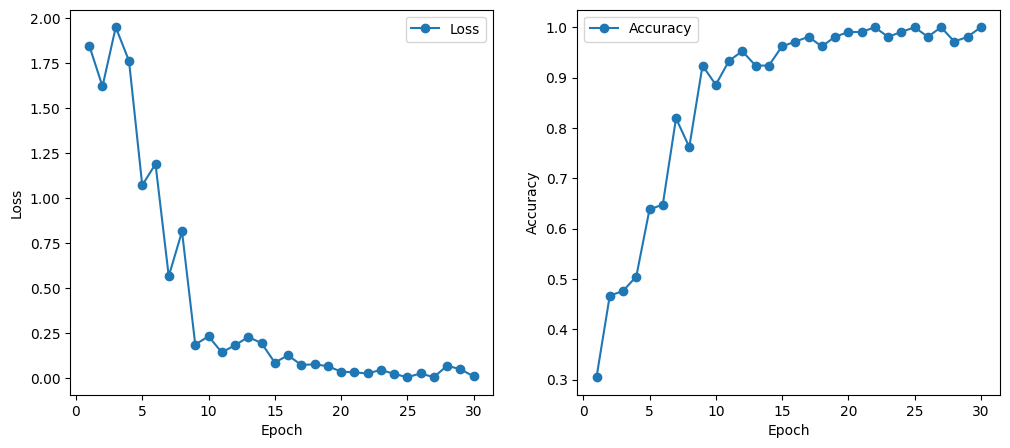


📊 Proposed ProtoNet + ResNet-18
Accuracy: 1.0000
Sensitivity (Recall): 1.0000
Specificity: 1.0000
Precision: 1.0000
F1-score: 1.0000
MCC: 1.0000


In [21]:
# Core Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, matthews_corrcoef
from PIL import Image
import os
import random

# Dataset
class FewShotDataset(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.transform = transform
        self.classes = sorted(os.listdir(dataset_path))
        self.image_paths = []
        self.labels = []

        for idx, cls in enumerate(self.classes):
            class_path = os.path.join(dataset_path, cls)
            for img_name in os.listdir(class_path):
                self.image_paths.append(os.path.join(class_path, img_name))
                self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        label = self.labels[index]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load Dataset
dataset_path = r"E:\1 Paper MCT\Cutting Tool Paper\Dataset\cutting tool data\test_data_40_images"
dataset = FewShotDataset(dataset_path, transform=transform)

# Few-shot split
from sklearn.model_selection import train_test_split

def split_support_query(dataset, n_way, k_shot, query_size):
    class_to_indices = {cls: [] for cls in range(len(dataset.classes))}
    for idx, (_, label) in enumerate(dataset):
        class_to_indices[label].append(idx)

    support_set = []
    query_set = []
    for cls in range(n_way):
        indices = class_to_indices[cls]
        support_indices, query_indices = train_test_split(indices, train_size=k_shot, test_size=query_size)
        support_set.extend(support_indices)
        query_set.extend(query_indices)

    return support_set, query_set

n_way = 7
k_shot = 5
query_size = 15
support_indices, query_indices = split_support_query(dataset, n_way, k_shot, query_size)

# Model
class Backbone(nn.Module):
    def __init__(self):
        super(Backbone, self).__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.model.fc = nn.Identity()

    def forward(self, x):
        return self.model(x)

class PrototypicalNetwork(nn.Module):
    def __init__(self, backbone):
        super(PrototypicalNetwork, self).__init__()
        self.backbone = backbone

    def compute_prototypes(self, support_embeddings, support_labels, n_way):
        prototypes = []
        for i in range(n_way):
            class_embeddings = support_embeddings[support_labels == i]
            prototypes.append(class_embeddings.mean(0))
        return torch.stack(prototypes)

    def forward(self, support_images, support_labels, query_images, n_way):
        support_embeddings = self.backbone(support_images)
        query_embeddings = self.backbone(query_images)
        prototypes = self.compute_prototypes(support_embeddings, support_labels, n_way)
        dists = torch.cdist(query_embeddings, prototypes)
        return dists

# Training
def train_prototypical_network(model, optimizer, dataset, support_indices, query_indices, n_way, k_shot, query_size, num_epochs, device):
    model.to(device)
    loss_history = []
    accuracy_history = []

    for epoch in range(num_epochs):
        model.train()
        support_images, support_labels, query_images, query_labels = [], [], [], []

        for idx in support_indices:
            img, label = dataset[idx]
            support_images.append(img)
            support_labels.append(label)

        for idx in query_indices:
            img, label = dataset[idx]
            query_images.append(img)
            query_labels.append(label)

        support_images = torch.stack(support_images).to(device)
        support_labels = torch.tensor(support_labels).to(device)
        query_images = torch.stack(query_images).to(device)
        query_labels = torch.tensor(query_labels).to(device)

        dists = model(support_images, support_labels, query_images, n_way)
        log_probs = -dists.log_softmax(dim=1)
        loss = nn.CrossEntropyLoss()(log_probs, query_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            preds = torch.argmin(dists, dim=1)
            accuracy = accuracy_score(query_labels.cpu(), preds.cpu())

        loss_history.append(loss.item())
        accuracy_history.append(accuracy)
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")

    return loss_history, accuracy_history

# Initialize
device = 'cuda' if torch.cuda.is_available() else 'cpu'
backbone = Backbone()
model = PrototypicalNetwork(backbone).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train
num_epochs = 30
loss_history, accuracy_history = train_prototypical_network(
    model, optimizer, dataset, support_indices, query_indices,
    n_way=n_way, k_shot=k_shot, query_size=query_size, num_epochs=num_epochs, device=device
)

# Plot
def plot_training_progress(loss_history, accuracy_history):
    epochs = range(1, len(loss_history) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_history, '-o', label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy_history, '-o', label='Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_training_progress(loss_history, accuracy_history)

# Evaluation
model.eval()
query_images, query_labels = [], []
for idx in query_indices:
    img, label = dataset[idx]
    query_images.append(img)
    query_labels.append(label)

query_images = torch.stack(query_images).to(device)
query_labels = torch.tensor(query_labels).to(device)

with torch.no_grad():
    support_images, support_labels = [], []
    for idx in support_indices:
        img, label = dataset[idx]
        support_images.append(img)
        support_labels.append(label)
    support_images = torch.stack(support_images).to(device)
    support_labels = torch.tensor(support_labels).to(device)

    dists = model(support_images, support_labels, query_images, n_way)
    preds = torch.argmin(dists, dim=1).cpu().numpy()
    true_labels = query_labels.cpu().numpy()

cm = confusion_matrix(true_labels, preds)
tp = np.diag(cm)
fp = cm.sum(axis=0) - tp
tn = cm.sum() - (cm.sum(axis=1) + fp - tp)
specificity = np.mean(tn / (tn + fp + 1e-8))

acc = accuracy_score(true_labels, preds)
prec = precision_score(true_labels, preds, average='macro', zero_division=1)
rec = recall_score(true_labels, preds, average='macro', zero_division=1)
f1 = f1_score(true_labels, preds, average='macro')
mcc = matthews_corrcoef(true_labels, preds)

print(f"\n\U0001F4CA Proposed ProtoNet + ResNet-18")
print(f"Accuracy: {acc:.4f}")
print(f"Sensitivity (Recall): {rec:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {prec:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")